In [2]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

To validata the approach, based on the RSSI measurement, one should cover such possible scenario:
* two different nodes at the same distance to ensure that the RSSI will be the same
* two nodes at the same distance simultaniously to ensure that the RSSI won't be affected by other sensors
* rssi at one meter with different time-length to determine how much time will be needed
* one node at the same distance, but in different locations

### Effect on each other test:
* two nodes at one meter

In [4]:
df = pd.read_csv("two_one_meter.csv", sep=";")
df["SP2"] = df[df["DEVICE"] == "SmartParking2"]["RSSI"]
df["SP1"] = df[df["DEVICE"] == "SmartParking1"]["RSSI"]
print(df.head())

sp1 = df["SP1"].apply(lambda x: abs(x)).dropna().values.tolist()
sp2 = df["SP2"].apply(lambda x: abs(x)).dropna().values.tolist()
print(sp1, sp2)

       TIME         DEVICE  RSSI   SP2   SP1
0  10:56:20  SmartParking2   -59 -59.0   NaN
1  10:56:25  SmartParking2   -60 -60.0   NaN
2  10:56:30  SmartParking1   -63   NaN -63.0
3  10:56:35  SmartParking1   -62   NaN -62.0
4  10:56:39  SmartParking1   -62   NaN -62.0
[63.0, 62.0, 62.0, 62.0, 62.0, 62.0, 62.0, 61.0, 57.0, 59.0, 62.0, 60.0, 61.0, 58.0, 61.0, 59.0, 60.0, 61.0] [59.0, 60.0, 60.0, 59.0, 61.0, 61.0, 62.0, 62.0, 60.0, 65.0, 60.0, 60.0, 58.0, 66.0, 60.0, 60.0, 59.0, 59.0, 62.0, 59.0]


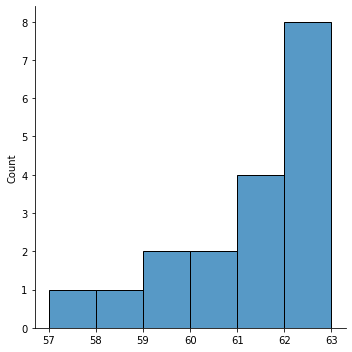

sp1 60.77777777777778


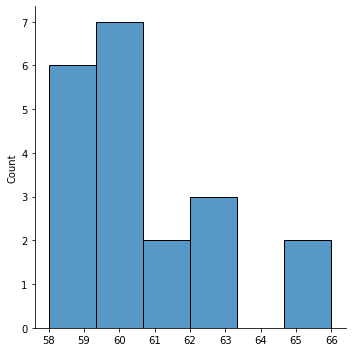

sp2 60.6


In [9]:
for data in [(sp1, "sp1"), (sp2, "sp2")]:
    sns.displot(data[0])
    plt.show()
    print(data[1], np.array(data[0]).mean())

Here the data was collected at the distance of one meter for two nodes, to ensure that the RSSI won't change from sensor to sensor.
<img src="examples/two_nodes_one_meter.PNG" alt="examples/two_sensors_one_meter" width="200"/>

P.S As the result even for two nodes simultaniuosly is the same, the comparisson at one meter for different sensors is omitted here

### One node in different locations

In [12]:
sm1_1_meter = np.array(pd.read_csv("sm2_1_meter.csv", sep=";")["RSSI"].apply(lambda x: abs(x)).values.tolist()).mean()
sm1_1_meter_dif_loc = np.array(pd.read_csv("sm2_1_meter_dif_loc.csv", sep=";")["RSSI"].apply(lambda x: abs(x)).values.tolist()).mean()

In [13]:
sm1_1_meter, sm1_1_meter_dif_loc

(65.5813953488372, 62.175)

As we can see, the RSSI is slightly changed, though it is predictable, as the major factor is the environmental propagation that changes it. Though, there is also a possibility that RSSI is not distributed sufficiently enough due to the lask of samples during the test.

Not to omit the fact, that during the first measurements there was a wall nearby

<img src="examples/one_meter_2.PNG" alt="two_sensors_one_meter" width="200" align="left"/>
<img src="examples/one_meter_dif_loc.PNG" alt="two_sensors_one_meter" width="200" align="left" padding-right=100px/>

m=0.010049683830171453, c=60.77085215296596


60.77085215296596

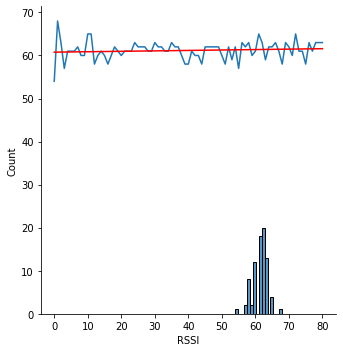

In [38]:
def stats_of(path_to_file):
    long_time = pd.read_csv(path_to_file, sep=";")
    long_time.head()
    data = long_time["RSSI"].apply(lambda x: abs(x))
    A = np.vstack([np.array(range(len(data))), np.ones(len(data))]).T
    m, c = np.linalg.lstsq(A, data, rcond=None)[0]
    print(f"{m=}, {c=}")
    sns.displot(data)
    plt.plot(data)
    plt.plot(m*range(len(data)) + c, 'r', label='Fitted line')
    # print(np.array(data).mean())
    # return np.array(data).mean()
    
    return c # this shows, how fat should we put the line, to
    # "take" the max amount of points in one line.

stats_of("long_time_one.csv") # test case

## Determination of Path Loss Index as a backbone of the system

Determiners:
* At two meters
    <img src="examples/two_meters.PNG" alt="two_meters" width="200"/>
* At three meters
    <img src="examples/three_meters.PNG" alt="three_meters" width="200"/>

One to determine then:
<img src="examples/to_determine_1_95.PNG" alt="to_determine" width="200"/>

m=0.004284447946419846, c=59.52097902097901


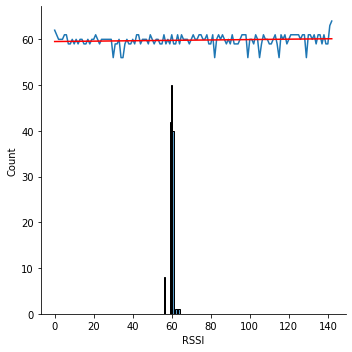

long_long_time.csv
m=0.009940970670283603, c=65.1781206171108


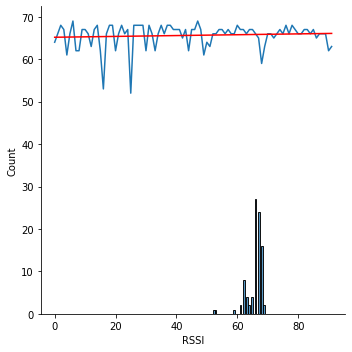

two_meters_sm2.csv
m=-0.009726873909145999, c=72.84362469927827


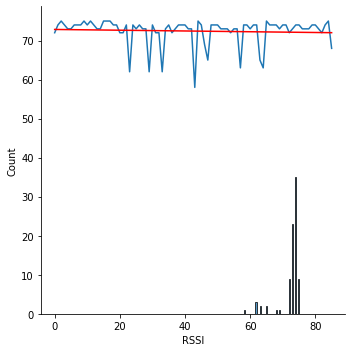

two_point_five_meters_sm2.csv
m=0.007642891867490942, c=73.40358126721763


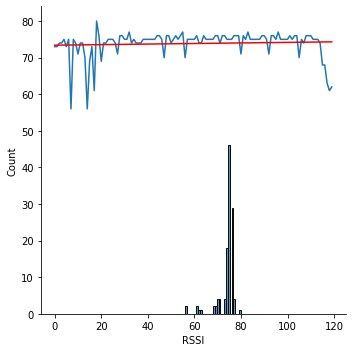

tthree_meters_sm2.csv
m=-0.002636670416198121, c=56.061617297837785


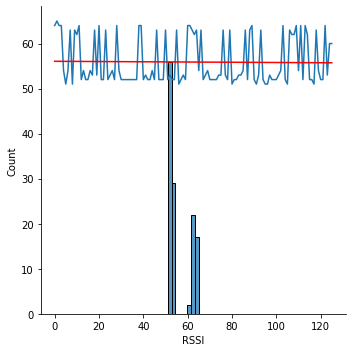

to_determine_sm2.csv


In [29]:
rssis = []
for path in ["long_long_time.csv", 'two_meters_sm2.csv', 'two_point_five_meters_sm2.csv',
            'tthree_meters_sm2.csv', 'to_determine_sm2.csv']:
    res = stats_of(path)
    plt.show()
    print(path)
    rssis.append(res)

In [30]:
def get_path_loss_index(tx_benchmark_power: int, RSSI: int,
                        benchmark_distance: float, RSSI_measured_distance: float):
    '''
    determines n - path loss index which depends on the
    propagation environment
    '''

    return (tx_benchmark_power - RSSI) / (10 * math.log(RSSI_measured_distance/benchmark_distance))


def get_distance(RSSI: int, tx_power: int, n: float): 
    '''
    Uses Log-distance path loss model
    '''
    
    return 10**((tx_power -  RSSI) / (10 * n))

In [31]:
from copy import deepcopy
rs = deepcopy(rssis)
rs # here rs contains as known element that will be used to determine path loss index
    # but also those that need to be determine

[59.52097902097901,
 65.1781206171108,
 72.84362469927827,
 73.40358126721763,
 56.061617297837785]

determination of loss index as a mean of measurements at certain distances



In [35]:
distances = [1, 2, 2.5, 3]
dist_to_rssi = list(zip(distances, rs[:-1]))
loss_indexes = []
for elm in dist_to_rssi:
    loss_indexes.append(get_path_loss_index(rs[0], elm[1], 1, elm[0]))
print(loss_indexes[1:])
LOSS_INDEX = round(abs(np.mean(loss_indexes[1:])), 2)
LOSS_INDEX 

[-0.8161530126346014, -1.4539758195577828, -1.2636489132184234]


<ipython-input-30-6e8373d3823d>:8: RuntimeWarning: invalid value encountered in double_scalars
  return (tx_benchmark_power - RSSI) / (10 * math.log(RSSI_measured_distance/benchmark_distance))


1.18

In [37]:
get_distance(rs[-1], rs[0], LOSS_INDEX)

1.9641119940978287